In [37]:
import liora
import odilon
import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup, NavigableString, Tag
import requests

pd.options.display.float_format = '{:,.2f}'.format

# Espera um pouco...

Antes de fazer olhar esse notebook, assegure-se que deu uma olhada nesse [arquivo](https://github.com/derekmartins/AnaliseCotaParlamentarDeputadosFederais/blob/main/Análise.md). Assim você terá uma visão geral do que foi feito.

In [38]:
dado = utils.carregar_dados_todos_anos()

## 1. Como se comportam os gastos com cotas parlamentares ao longo do tempo? Existe alguma tendência de aumento ou redução desse custo?

Para entender o comportamento dos gastos, precisamos entender como funciona o Acúmulo da Cota Parlamentar

## Como funciona o Acúmulo da Cota Parlamentar?

O valor da cota pode ser acumulado durante o Exercício Financeiro. O que sobra de um Exercício Financeiro não pode ser utilizado no Exercício Financeiro Seguinte.
Um Exercicio Financeiro possui duração de um ano. Começando a partir do dia 01 de janeiro do referido ano.

Com isso em mente, podemos concluir que:
- O mês de menor gasto, é Abril de 2020, mês posterior à Pandemia causada pelo Covid-19.
- O dinheiro acumulou-se e o prazo máximo para consumir esse dinheiro era dezembro de 2020.
- Tendo isso em mente, provavelmente o final do exercício de parlamentar deve ter os maiores gastos.
- Logo, percebemos que o mês com maior gasto é dezembro de 2020 (final do Exercício Financeiro de 2020), confirmando a hipótese acima. 

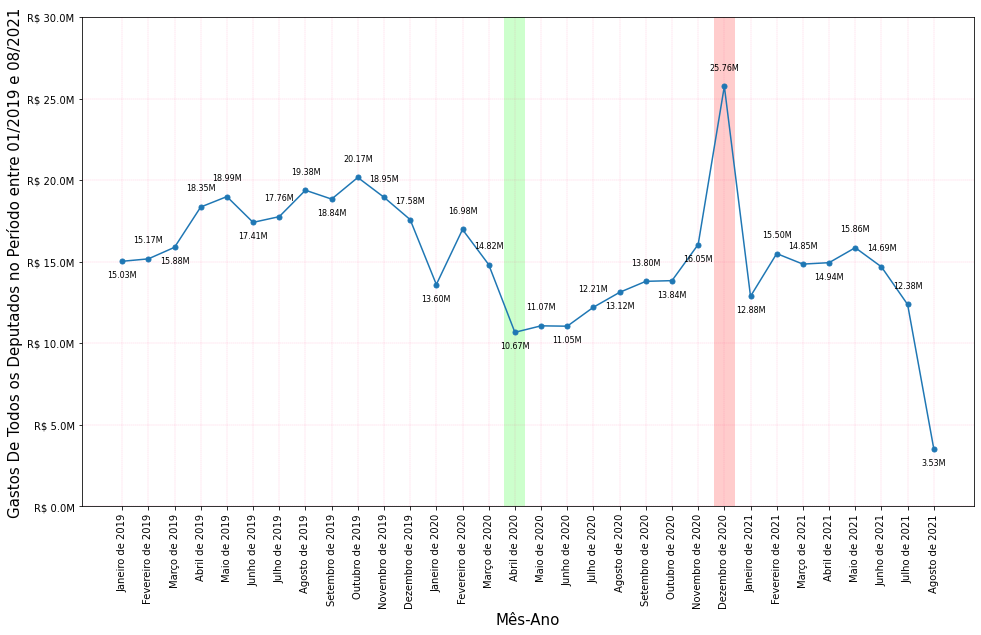

In [39]:
base = 1000000

minimo, maximo = 0, 30_000_000


colunas_analisadas = ['numAno', 'numMes', 'vlrDocumento', 'vlrLiquido']
analise = dado[colunas_analisadas]
analise_por_mes = analise.groupby(['numAno', 'numMes']).sum()

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

analise_por_mes.vlrDocumento.plot(style='-o', ax=ax, figsize=(16, 9), ms=5)

indices = analise_por_mes.index.to_frame()
indices = indices.numMes.astype(str) + '/' + indices.numAno.astype(str)
indices = indices.to_numpy()
indices = utils.formatar_datas_para_rotulo(pd.Series(indices))

min_y, max_y = utils.gerar_limites_eixo_y(
    analise_por_mes.vlrDocumento.to_numpy())
yticks = np.linspace(minimo, maximo, 7)

ax.set_xticks(range(len(indices)))
ax.set_xticklabels(indices, rotation=90)
ax.grid(color=(1, 0.2, 0.5, 0.3), linestyle=':', linewidth=0.25)
ax.set_ylim([min_y, max_y])
ax.set_xlabel('Mês-Ano', fontsize=15)
ax.set_ylabel(
    'Gastos De Todos os Deputados no Período entre 01/2019 e 08/2021', fontsize=15)

ax.set_yticks(yticks)

yticks = [f'R$ {x/1000000}M' for x in yticks]
ax.set_yticklabels(yticks)

valores = analise_por_mes.vlrDocumento.to_numpy()
valores = np.concatenate(([max_y], valores, [max_y]))

direcao_desvio = np.sign(np.diff(valores))
direcao_desvio[[2, 19, 21, 22, 27]] = -1
direcao_desvio[[10, 11, 14, 20, 26, 29, 30]] = 1
desvios = direcao_desvio * (max_y/30)

interate = zip(desvios, analise_por_mes.vlrDocumento.to_numpy())


for eixo_x, (desvio_y, valor) in enumerate(interate):
    valor_sem_resto = valor - (valor % (base/100))
    coordenadas = (eixo_x, valor_sem_resto + desvio_y)
    ax.annotate(f'{(valor_sem_resto/base):4.2f}M',
                coordenadas, fontsize=8, ha='center')

# plt.savefig('Gasto Total sem Barra Vertical.png', dpi=150, bbox_inches='tight')
plt.bar([23, 15], [max_y, max_y], color=['#ffcccc', '#ccffcc'])
# plt.savefig('Gasto Total com Barra Vertical.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Qual a Média de Gastos por Parlamentar?

In [40]:
colunas_analisadas = ['vlrLiquido', 'vlrDocumento', 'txNomeParlamentar']
soma_gasto_parlamentar = utils.soma_gastos(dado[colunas_analisadas]).sort_values(colunas_analisadas)


numeric_columns = soma_gasto_parlamentar.select_dtypes(float).columns
soma_gasto_parlamentar[numeric_columns] = soma_gasto_parlamentar[numeric_columns].apply(lambda x:x/31)
soma_gasto_parlamentar.iloc[np.r_[0:5, -5:0]]

,txNomeParlamentar,vlrLiquido,vlrDocumento
399,Jorge Goetten,-787.18,"1,339.22"
703,Renato Queiroz,-293.78,846.89
254,FELIPE BORNIER,-54.03,-54.03
464,LUCIANA SANTOS,0.02,0.02
515,MANDETTA,0.02,0.02
418,João Maia,"42,939.72","42,962.77"
277,Flaviano Melo,"42,959.63","43,525.87"
757,Silas Câmara,"43,851.98","44,314.68"
828,Wellington Roberto,"44,066.44","44,680.35"
431,Jéssica Sales,"45,660.00","45,681.72"


## 3. Quais foram os parlamentares que mais e que menos consumiram recursos?


### Deputada que mais gastou. 

A parlamentar que mais consumiu Cota Parlamentar foi a Deputadada Jéssica Sales.
Podemos levar em consideração que o Acre possui os maiores valores de cota devido à dificuldade em chegar ao Distrito Federal.

### Deputado que menos gastou.

A parlamentar que menos consumiu Cota Parlamentar foi a Deputadada Felipe Bornier.
Entretanto, os valores encontrados foram do mandato passado e além disso, ele renunciou logo no começo do mandato.

In [41]:
idx = [
    soma_gasto_parlamentar.vlrDocumento.idxmax(), 
    soma_gasto_parlamentar.vlrDocumento.idxmin()]

print(idx)

soma_gasto_parlamentar.loc[idx]

[431, 254]


,txNomeParlamentar,vlrLiquido,vlrDocumento
431,Jéssica Sales,"45,660.00","45,681.72"
254,FELIPE BORNIER,-54.03,-54.03


## 4. Quais são as categorias de despesas mais onerosas dentre os recursos destinados às cotas parlamentares?

A categoria com maior despesa é a Divulgação da Atividade Parlamentar, com um gasto de aproximandade 138 Milhões de Reais, isso inclui televisão, website, rádio, mídias sociais, entre outros.

txtDescricao
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.            137,173,739.89
PASSAGEM AÉREA - RPA                             72,410,281.97
LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES    67,401,578.92
Name: vlrLiquido, dtype: float64

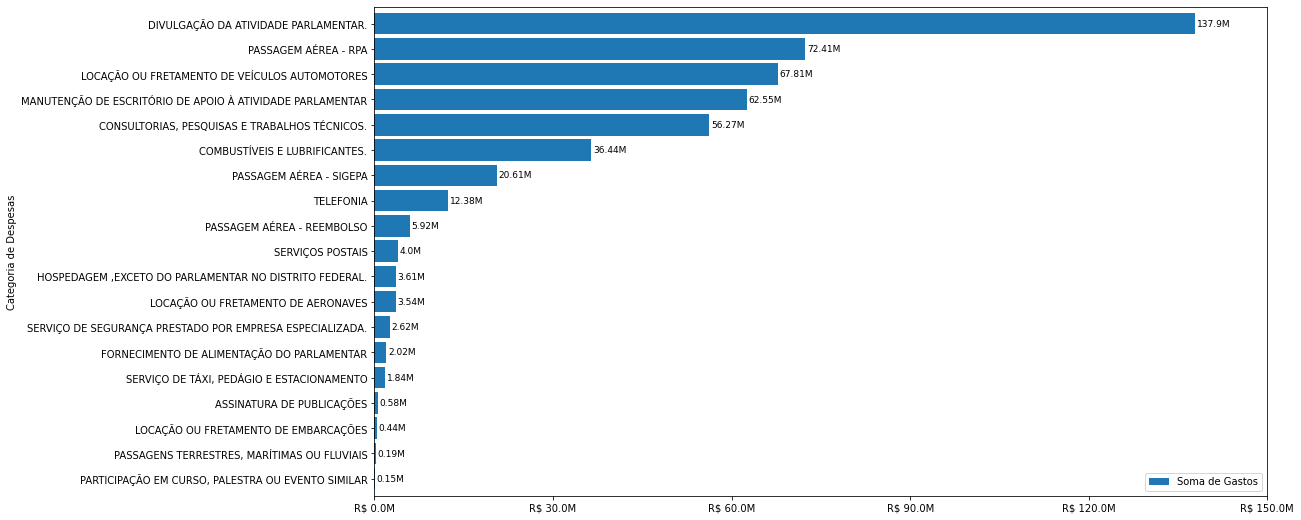

In [42]:
display(liora.categoria_despesa_onerosa(dado))

col = ['txtDescricao', 'vlrDocumento']
gastos_estado = dado[col]
sgc = utils.soma_gastos(gastos_estado)
sgc = sgc.sort_values('vlrDocumento')
sgc.columns = ['Categoria de Despesas', 'Soma de Gastos']

mx = 150_000_000

fig, ax = plt.subplots()

fig.patch.set_facecolor('white')
sgc.set_index('Categoria de Despesas').plot.barh(
    figsize=(16,9),
    width=.85,
    ax=ax
)

ax.set_facecolor('white')

# Ajustar As Anotações
ax.set_xlim(0, mx)
labels = (sgc['Soma de Gastos'] / 1_000_000).round(2).to_numpy()
for x, y in enumerate(sgc['Soma de Gastos']):
    text = f'{labels[x]}M'
    ax.annotate(text,(y + 250000, x), va='center', fontsize=9)
ax.legend(loc=4)

# Ajustar o Eixo X

yticks = [x for x in range(0, mx+1, int(mx/5))]
ax.set_xticks(yticks)


yticks = [f'R$ {x/1000000}M' for x in yticks]
ax.set_xticklabels(yticks);


## 5. Quais são os trechos de viagem mais recorrentes entre as despesas de viagem?

O trecho mais recorrente é de Brasília para Brasília, uma possível explicação é o fato dos candidatos poderem alugar aeronaves para facilitar a locomoção dentro da cidade de Brasilia.

In [43]:
liora.trecho_viagem_recorrente(dado)

BSB/BSB    9890
BSB/CGH    5083
CGH/BSB    4912
Name: txtTrecho, dtype: int64

## 6. Qual a média de gastos por estado?

[Text(0, 0, 'R$ 0.0M'),
 Text(500000, 0, 'R$ 0.5M'),
 Text(1000000, 0, 'R$ 1.0M'),
 Text(1500000, 0, 'R$ 1.5M'),
 Text(2000000, 0, 'R$ 2.0M')]

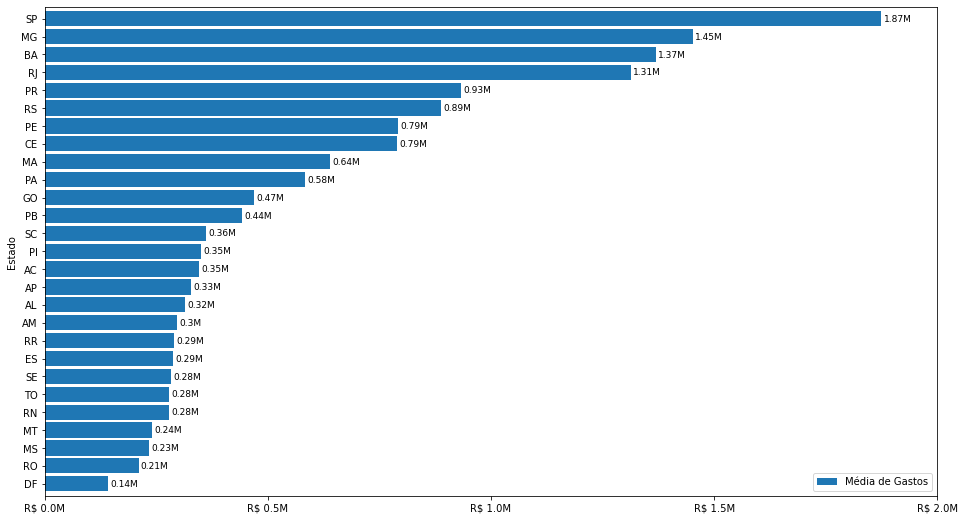

In [44]:
col = ['sgUF', 'vlrDocumento']
gastos_estado = dado[col]
sge = utils.soma_gastos(gastos_estado)
sge.vlrDocumento = sge.vlrDocumento / 31
sge = sge.sort_values('vlrDocumento')
sge.columns = ['Estado', 'Média de Gastos']

mx = 2_000_000

fig, ax = plt.subplots()

fig.patch.set_facecolor('white')
sge.set_index('Estado').plot.barh(
    figsize=(16,9),
    width=.85,
    ax=ax
)

ax.set_facecolor('white')

# Ajustar As Anotações
ax.set_xlim(0, mx)
labels = (sge['Média de Gastos'] / 1_000_000).round(2).to_numpy()
for x, y in enumerate(sge['Média de Gastos']):
    text = f'{labels[x]}M'
    ax.annotate(text,(y + 5000, x), va='center', fontsize=9)
ax.legend(loc=4)

# Ajustar o Eixo X

yticks = [x for x in range(0, mx+1, int(mx/4))]

ax.set_xticks(yticks)


yticks = [f'R$ {x/1000000}M' for x in yticks]
ax.set_xticklabels(yticks)

## 7. Qual é o valor total de gastos por estado?

[Text(0, 0, 'R$ 0.0M'),
 Text(10000000, 0, 'R$ 10.0M'),
 Text(20000000, 0, 'R$ 20.0M'),
 Text(30000000, 0, 'R$ 30.0M'),
 Text(40000000, 0, 'R$ 40.0M'),
 Text(50000000, 0, 'R$ 50.0M'),
 Text(60000000, 0, 'R$ 60.0M'),
 Text(70000000, 0, 'R$ 70.0M')]

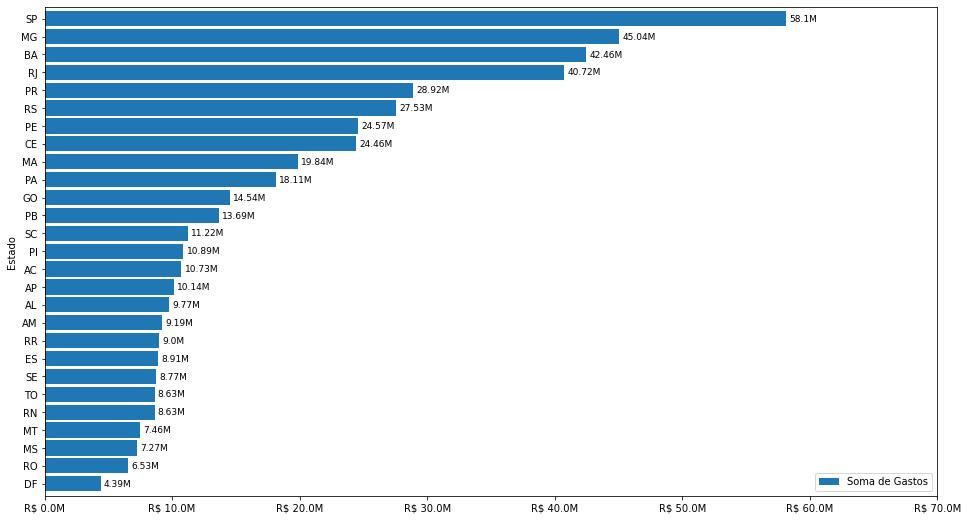

In [45]:
odilon.valor_total_de_gasto_estado(dado)

col = ['sgUF', 'vlrDocumento']
gastos_estado = dado[col]
sge = utils.soma_gastos(gastos_estado)
sge = sge.sort_values('vlrDocumento')
sge.columns = ['Estado', 'Soma de Gastos']

mx = 70_000_000

fig, ax = plt.subplots()

fig.patch.set_facecolor('white')
sge.set_index('Estado').plot.barh(
    figsize=(16,9),
    width=.85,
    ax=ax
)

ax.set_facecolor('white')

# Ajustar As Anotações
ax.set_xlim(0, mx)
labels = (sge['Soma de Gastos'] / 1_000_000).round(2).to_numpy()
for x, y in enumerate(sge['Soma de Gastos']):
    text = f'{labels[x]}M'
    ax.annotate(text,(y + 250000, x), va='center', fontsize=9)
ax.legend(loc=4)

# Ajustar o Eixo X

yticks = [x for x in range(0, mx+1, int(mx/7))]

ax.set_xticks(yticks)


yticks = [f'R$ {x/1000000}M' for x in yticks]
ax.set_xticklabels(yticks)

## 8. Quais estados possuem maior número de representantes?

Baseado nesses [dados](https://www2.camara.leg.br/a-camara/conheca/numero-de-deputados-por-estado),sabemos que os estados com maiores número de parlamentares são:
- **São Paulo**: 70 Deputados
- **Minas Gerais**: 53 Deputados
- **Rio De Janeiro**: 46 Deputados
- **Bahia**: 39 Deputados

A quantidade de Parlamentares por Estado é proporcional à População do Estado.
O fato dos valores serem discrepantes do dado fornecido pela Câmara é devido à não exclusão dos dados dessa Análise.
Muitos candidatos abriram mão do Cargo para assumirem outras posições, como Prefeituras, Ministérios ou simplesmente renunciaram.

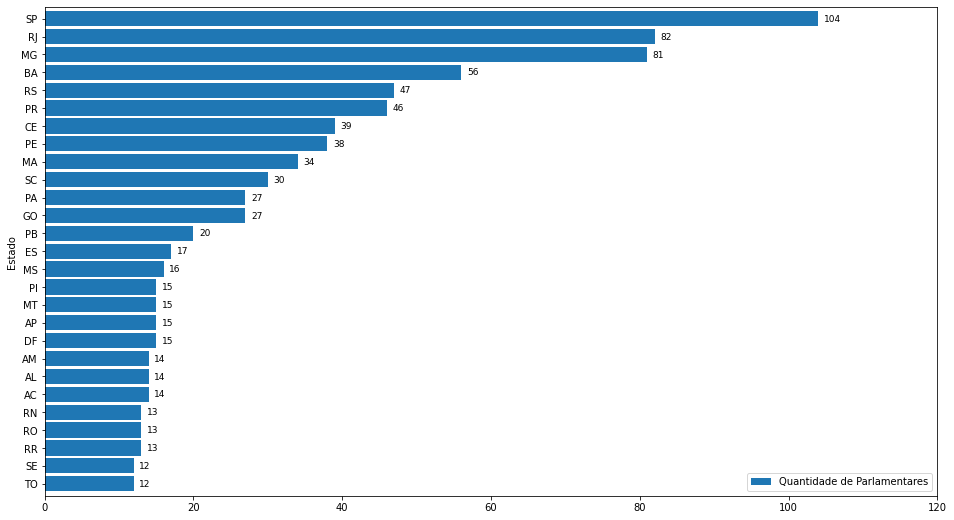

In [46]:
col = ['sgUF', 'txNomeParlamentar']
npe = dado[col].drop_duplicates().copy()

npe = npe.groupby('sgUF').count().reset_index()
npe.columns = ['Estado', 'Quantidade de Parlamentares']
npe = npe.sort_values('Quantidade de Parlamentares')
npe

mx = 120

fig, ax = plt.subplots()

fig.patch.set_facecolor('white')
npe.set_index('Estado').plot.barh(
    figsize=(16,9),
    width=.85,
    ax=ax
)

ax.set_facecolor('white')

# Ajustar As Anotações
ax.set_xlim(0, mx)
labels = npe['Quantidade de Parlamentares'].to_numpy()
for x, y in enumerate(npe['Quantidade de Parlamentares']):
    text = f'{labels[x]}'
    ax.annotate(text,(y+0.75, x), va='center', fontsize=9)
ax.legend(loc=4)

## 9. Há alguma correlação entre a quantidade de parlamentares por estado e o valor total dos gastos ?

- Há uma Correlação de Positiva e Forte.
- Pelo gráfico de regressão, podemos perceber que há um crescimento proporcional entre Quantidade de Parlamentares por Estado e o Valor Total Gasto por Estado.
- Isso indica que sim, há uma correlação entre Quantidade de Parlamentares por Estado e o Valor Total Gasto por Estado.

,Soma de Gastos por Estado,Quantidade de Parlamentares
Soma de Gastos por Estado,1.00,0.97
Quantidade de Parlamentares,0.97,1.00


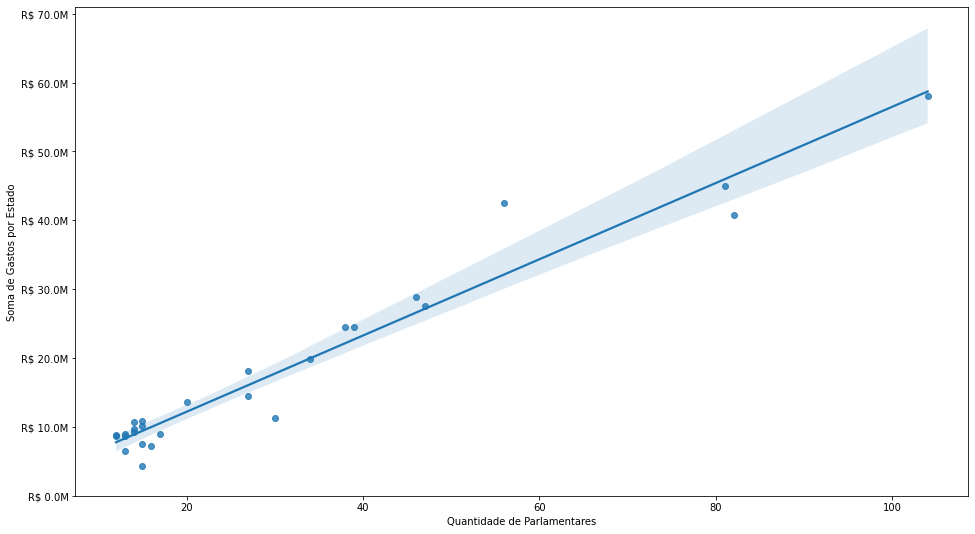

In [47]:
col = ['sgUF', 'vlrDocumento']
gastos_estado = dado[col]
sge = utils.soma_gastos(gastos_estado)
sge = sge.sort_values('vlrDocumento')
sge.columns = ['Estado', 'Soma de Gastos']

col = ['sgUF', 'txNomeParlamentar']
npe = dado[col].drop_duplicates().copy()

npe = npe.groupby('sgUF').count().reset_index()
npe.columns = ['Estado', 'Quantidade de Parlamentares']
npe = npe.sort_values('Quantidade de Parlamentares')

my = 70_000_000
mx = 120
cpg = pd.DataFrame()

cpg = pd.concat([sge['Soma de Gastos'], npe['Quantidade de Parlamentares']], axis=1)
cpg.columns = ['Soma de Gastos por Estado', 'Quantidade de Parlamentares']
display(cpg.corr())

fig, ax = plt.subplots(figsize=(16,9))
fig.patch.set_facecolor('white')

sns.regplot(y='Soma de Gastos por Estado', x='Quantidade de Parlamentares', data=cpg, ax=ax)

yticks = [x for x in range(0, my+1, int(my/7))]

# for y in yticks:
#     print(y)

ax.set_yticks(yticks)

yticks = [f'R$ {x/1_000_000}M' for x in yticks]
ax.set_yticklabels(yticks);

## 10. Qual a média de gastos por partido?

[Text(0, 0, 'R$ 0.0M'),
 Text(10000000, 0, 'R$ 10.0M'),
 Text(20000000, 0, 'R$ 20.0M'),
 Text(30000000, 0, 'R$ 30.0M'),
 Text(40000000, 0, 'R$ 40.0M'),
 Text(50000000, 0, 'R$ 50.0M'),
 Text(60000000, 0, 'R$ 60.0M')]

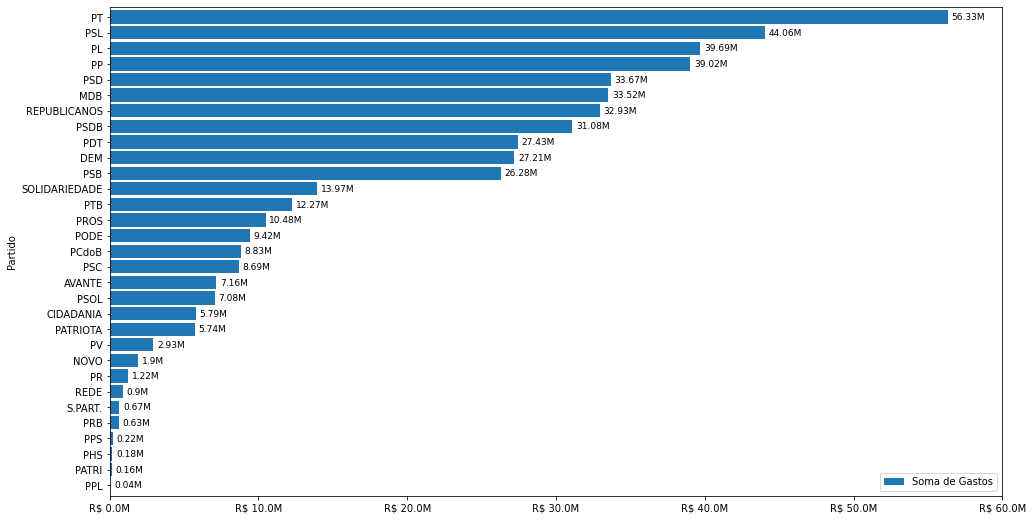

In [48]:
col = ['sgPartido', 'vlrDocumento']
npp = dado[col].copy()

npp = utils.soma_gastos(npp)
npp.columns = ['Partido', 'Soma de Gastos']
npp = npp.sort_values('Soma de Gastos')

mx = 60_000_000

fig, ax = plt.subplots()

fig.patch.set_facecolor('white')

npp.set_index('Partido').plot.barh(
    figsize=(16,9),
    width=.85,
    ax=ax
)

ax.set_facecolor('white')

# Ajustar As Anotações
ax.set_xlim(0, mx)

labels = (npp['Soma de Gastos'] / 1_000_000).round(2).to_numpy()
for x, y in enumerate(npp['Soma de Gastos']):
    text = f'{labels[x]}M'
    ax.annotate(text,(y + 250000, x), va='center', fontsize=9)
ax.legend(loc=4)

# Ajustar o Eixo X

yticks = [x for x in range(0, mx+1, int(mx/6))]

ax.set_xticks(yticks)


yticks = [f'R$ {x/1000000}M' for x in yticks]
ax.set_xticklabels(yticks)

##  11. Quais são os partidos que mais e que menos consumiram a cota parlamentar?

O partido que mais gastou foi o **PT**, com aproximadamente **56.3 Milhões de Reais**, enquanto o **PPL** gastou em torno de **45 Mil Reais**.

In [49]:
colunas_analisadas = ['vlrDocumento', 'sgPartido']
soma_gasto_partido = utils.soma_gastos(
    dado[colunas_analisadas]).sort_values(colunas_analisadas)


numeric_columns = soma_gasto_partido.select_dtypes(float).columns
idx = [
    soma_gasto_partido.vlrDocumento.idxmax(),
    soma_gasto_partido.vlrDocumento.idxmin()
]

soma_gasto_partido.loc[idx].set_index('sgPartido')


,vlrDocumento
sgPartido,
PT,"56,328,962.20"
PPL,"44,925.75"


##  12. Há alguma correlação entre a quantidade de parlamentares por partido e o valor total dos gastos?

- Há uma Correlação de Positiva e Forte.
- Pelo gráfico de regressão, podemos perceber que há um crescimento proporcional entre Quantidade de Parlamentares por Partido e o Valor Total Gasto por Partido.
- Isso indica que sim, há uma correlação entre Quantidade de Parlamentares por Partido e o Valor Total Gasto por Partido.

,Soma de Gastos por Partido,Quantidade de Parlamentares
Soma de Gastos por Partido,1.00,0.91
Quantidade de Parlamentares,0.91,1.00


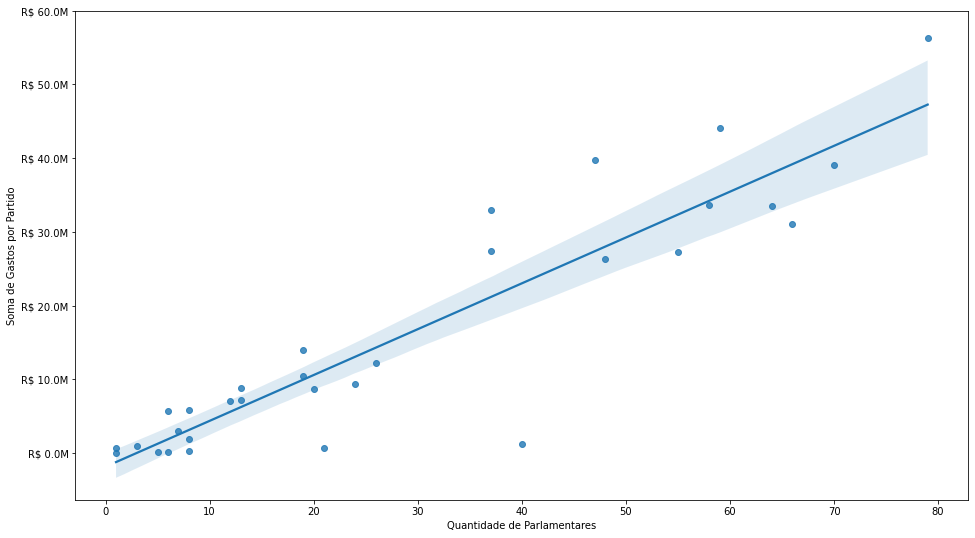

In [50]:
col = ['sgPartido', 'txNomeParlamentar']
npp = dado[col].drop_duplicates().copy()

npp = npp.groupby('sgPartido').count().reset_index()
npp.columns = ['Partido', 'Quantidade de Parlamentares']
npp = npp.sort_values('Quantidade de Parlamentares')

colunas_analisadas = ['sgPartido', 'vlrDocumento']
sgp = utils.soma_gastos(dado[colunas_analisadas]).sort_values('vlrDocumento')
sgp.columns = ['Partido', 'Soma de Gastos por Partido']

csgp =  sgp.set_index('Partido').join(npp.set_index('Partido'))

display(csgp.corr())
my = 60_000_000
fig, ax = plt.subplots(figsize=(16,9))
fig.patch.set_facecolor('white')

sns.regplot(data=csgp, x='Quantidade de Parlamentares', y='Soma de Gastos por Partido')

yticks = [x for x in range(0, my+1, int(my/6))]

ax.set_yticks(yticks)

yticks = [f'R$ {x/1_000_000}M' for x in yticks]
ax.set_yticklabels(yticks);

# Perguntas Extras


# 13. Qual são as 5 empresas (Fornecedores) mais receberam dinheiro?


Por mais que a maior parte dos gastos seja em Divulgação Parlamentar.
A maior concentração de gastos estão nas empresas de aviação, podemos notar que o top 3 é constituído por 3 Companhias Aéreas: **TAM**, **GOL** e **AZUL**.
Isso se deve ao fato dessas empresas serem de âmbito nacional, enquanto as empresas de Divulgação Parlamentar é de Âmbito Municipal ou Estadual.

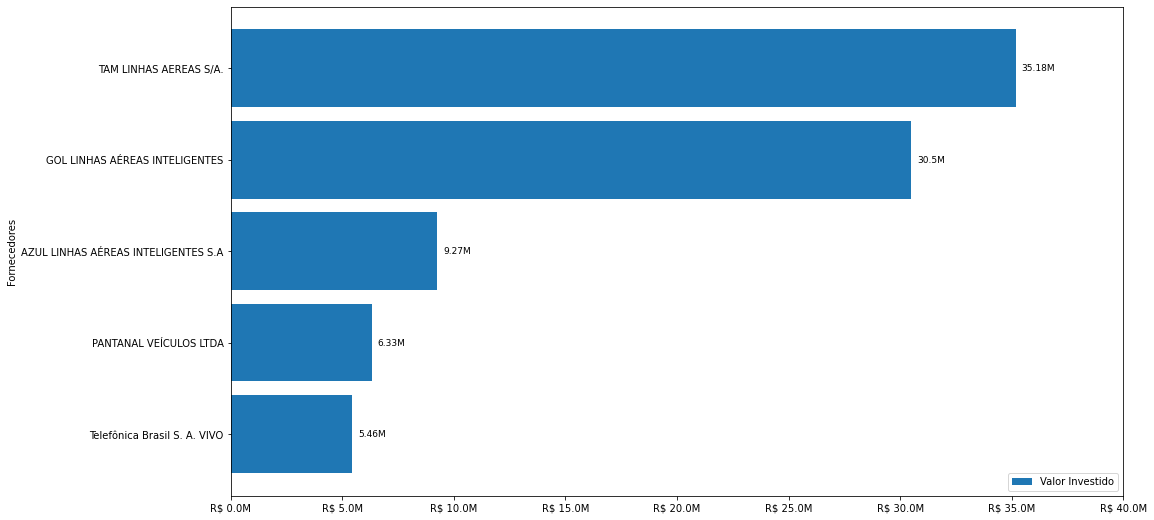

In [51]:
colunas_analisadas = ['txtCNPJCPF', 'vlrDocumento']
df = dado[colunas_analisadas]
gpcnpj = utils.soma_gastos(df).sort_values('vlrDocumento', ascending=False).reset_index()[:5].copy()

l = []

for cnpj in gpcnpj.nlargest(5, columns='vlrDocumento').txtCNPJCPF:
    l.append(utils.buscar_por_cnpj(dado, cnpj).txtFornecedor.unique()[0])


gpcnpj['Fornecedor'] = pd.Series(l)


col = ['Fornecedor', 'vlrDocumento']
#soma de gastos por fornecedor
sgf = gpcnpj[col].copy()

sgf.columns = ['Fornecedores', 'Valor Investido']


sgf = sgf.sort_values(sgf.columns[1])


mx = 40_000_000

fig, ax = plt.subplots()

fig.patch.set_facecolor('white')

sgf.set_index(sgf.columns[0]).plot.barh(
    figsize=(16,9),
    width=.85,
    ax=ax
)

ax.set_facecolor('white')

# Ajustar As Anotações
ax.set_xlim(0, mx)

labels = (sgf[sgf.columns[1]] / 1_000_000).round(2).to_numpy()
for x, y in enumerate(sgf[sgf.columns[1]]):
    text = f'{labels[x]}M'
    ax.annotate(text,(y + 250000, x), va='center', fontsize=9)
ax.legend(loc=4)

# Ajustar o Eixo X

yticks = [x for x in range(0, mx+1, int(mx/8))]

ax.set_xticks(yticks)


yticks = [f'R$ {x/1000000}M' for x in yticks]
ax.set_xticklabels(yticks);

plt.savefig('Décima Terceira.png', bbox_inches='tight')

## 14. Quais deputados foram eleitos, mas não estão inclusos no Dataset?

16 candidatos são listados no site da Câmara que não estão na base de dados.
Os únicos que realmente não gastaram um centavo da Cota Parlamentar são: **Hercílio Diniz** e **Paula Belmonte**.

In [52]:
url = "https://www.camara.leg.br/cota-parlamentar/"
request = requests.get(url)
site = BeautifulSoup(request.content, 'html.parser')

deputados = site.findAll(id='listaDeputados')[0]


def append_map_codigo_nome_deputado(tag, lista):
    for child in tag.children:
        mapa = {
            "Nome do Deputado": child.contents[0].strip(),
            "Código do Deputado": child.attrs['id'],
        }
        lista.append(mapa)

dados = []

for deputado in deputados:
    if isinstance(deputado, NavigableString):
        continue
    for content in deputado.contents:
        if content == "\n":
            continue

        if content.name == 'label':
            append_map_codigo_nome_deputado(content, dados)

nomes_deputados = pd.DataFrame(dados)['Nome do Deputado'].to_numpy()

nomes_deputados_df = dado.txNomeParlamentar.unique()

pd.DataFrame(np.setdiff1d(nomes_deputados, nomes_deputados_df), columns=['Deputados Não Inclusos na Análise (2019-2023)'])

,Deputados Não Inclusos na Análise (2019-2023)
0,Alencar Santana
1,Capitão Derrite
2,Ely Santos
3,Hercílio Coelho Diniz
4,Jones Moura
5,Jorielson
6,Leo de Brito
7,Marcelo Squassoni
8,Nelho Bezerra
9,Osmar Serraglio
